# Transfter learning
Train the [flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers), see all the [catalog](https://www.tensorflow.org/datasets/catalog/overview) using a pretrained mobilenet_v2 model. See also the full model for classification [here](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4).

Tutorilaes:
[1] [Youtube](https://www.youtube.com/watch?v=LsdxvjLWkIY) based on:
[2] [keras offcial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)

In [1]:
import os
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import cv2
import PIL.Image as Image
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential


In [2]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


TF version: 2.9.1
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [3]:
FLOWERS_DATASET_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#FLOWERS_DATASET_URL = "https://www.tensorflow.org/datasets/catalog/tf_flowers"
TFHUB_MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
LABELS_FILE = "data/labels.txt"
IMAGE_SHAPE = (224,224)
RANDOM_SEED = 42
MOBILNET_FEATURE_V2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

### Download pretrained model from [Tensorflow_hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4)


In [4]:
classifier = Sequential([hub.KerasLayer(TFHUB_MODEL_URL)])

### Run it on a single image

In [5]:
goldfish = Image.open('data/goldfish.jpg').resize(IMAGE_SHAPE)

In [6]:
goldfish = np.array(goldfish)/255.0
goldfish.shape


(224, 224, 3)

In [7]:
goldfish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [8]:
result = classifier.predict(goldfish[np.newaxis, ...])
result.shape


1/1 [==============================] - 1s 1s/step


(1, 1001)

In [9]:
result

array([[ 0.25913802,  1.7096896 ,  9.840893  , ..., -1.2328748 ,
        -0.54208255, -0.36059877]], dtype=float32)

In [10]:
predicted_class = np.argmax(result)

In [11]:
imagenet_labels = np.array(open(LABELS_FILE).read().splitlines())

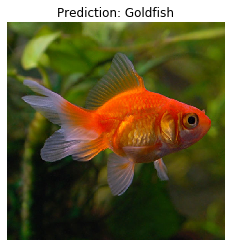

In [12]:
plt.imshow(goldfish)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Download from [tf](https://www.tensorflow.org/tutorials/load_data/images) 

In [13]:
data_dir = tf.keras.utils.get_file(origin=FLOWERS_DATASET_URL, fname='flower_photos', untar=True)

In [14]:
photos_folder = Path(data_dir)

In [15]:
list(photos_folder.glob('*/*.jpg'))[:5]

[PosixPath('/home/ubuntu/.keras/datasets/flower_photos/sunflowers/5139969631_743880e01d_n.jpg'),
 PosixPath('/home/ubuntu/.keras/datasets/flower_photos/sunflowers/164670455_29d8e02bbd_n.jpg'),
 PosixPath('/home/ubuntu/.keras/datasets/flower_photos/sunflowers/13117907313_86c99c6441.jpg'),
 PosixPath('/home/ubuntu/.keras/datasets/flower_photos/sunflowers/2894191705_a1d2d80c80.jpg'),
 PosixPath('/home/ubuntu/.keras/datasets/flower_photos/sunflowers/5957007921_62333981d2_n.jpg')]

In [16]:
image_count = len(list(photos_folder.glob('*/*.jpg')))

In [17]:
image_count

3670

In [18]:
flowers_images_dict =  list(photos_folder.glob('roses/*.jpg'))[:5]

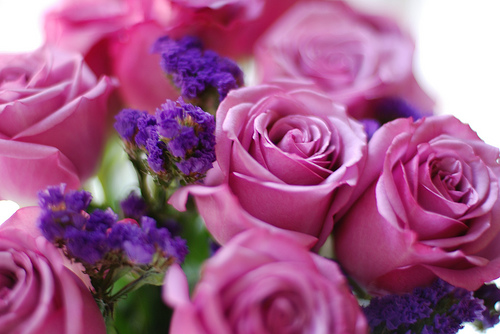

In [19]:
Image.open(list(photos_folder.glob('roses/*.jpg'))[1])

In [20]:
flower_types = [str(s).split('/')[-1] for s in photos_folder.glob("*") if s.is_dir()]
print(f"We have {len(flower_types)} flower types: {flower_types}")

We have 5 flower types: ['sunflowers', 'tulips', 'dandelion', 'roses', 'daisy']


In [21]:
flowers_images_dict = {flower_type:list(photos_folder.glob(f'{flower_type}/*.jpg')) for flower_type in flower_types}

In [22]:
flowers_labels_dict = {flower_type:i for i,flower_type in enumerate(flower_types)}

In [23]:
flowers_labels_dict

{'sunflowers': 0, 'tulips': 1, 'dandelion': 2, 'roses': 3, 'daisy': 4}

In [24]:
img = cv2.imread(str(flowers_images_dict['tulips'][5]))
cv2.resize(img, IMAGE_SHAPE).shape

(224, 224, 3)

In [25]:
X,y = [],[]

for flower_name,images in tqdm(flowers_images_dict.items()):
    for image_fn in tqdm(images):
        image = cv2.imread(str(image_fn))
        X.append(cv2.resize(image, IMAGE_SHAPE))
        y.append(flowers_labels_dict[flower_name])
                 

In [26]:
X = np.array(X)
y = np.array(y)

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=RANDOM_SEED)

In [28]:
classifier.predict(np.array([X[0]/256,X[1]/256,X[2]/256]))

1/1 [==============================] - 0s 46ms/step


array([[ 3.0971727e-01,  1.1217491e-01,  4.2405140e-01, ...,
        -2.7007455e-01,  1.3181038e+00, -7.3135054e-01],
       [ 1.4388368e-01, -7.5441074e-01,  1.7266963e-01, ...,
        -2.0087466e+00,  4.1518107e-02, -5.3879148e-01],
       [ 2.2465888e-01,  9.2657313e-02,  1.8033175e-01, ...,
        -1.2549534e-03, -4.3495291e-01, -1.1514930e+00]], dtype=float32)

In [29]:
[imagenet_labels[n] for n in np.argmax(classifier.predict(np.array([X[0]/255,X[1]/255,X[2]/255])),axis=1)]

1/1 [==============================] - 0s 42ms/step


['sea urchin', 'daisy', 'daisy']

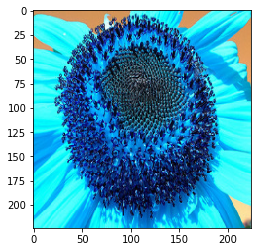

In [30]:
plt.imshow(X[0])

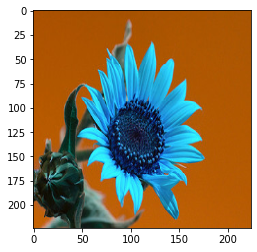

In [31]:
plt.imshow(X[1])

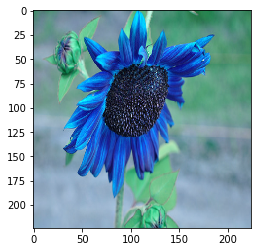

In [32]:
plt.imshow(X[2])

In [33]:
feature_extractor_layer = hub.KerasLayer(MOBILNET_FEATURE_V2, input_shape=(224, 224, 3), trainable=False)


In [34]:
num_classes = len(flower_types)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(
#    log_dir=log_dir,
#    histogram_freq=1) # Enable histogram computation for every epoch.


In [36]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [37]:
%%time
history = model.fit(X_train_scaled,y_train,epochs=5)

Epoch 1/5
86/86 [==============================] - 22s 211ms/step - loss: 0.8288 - acc: 0.6879
Epoch 2/5
86/86 [==============================] - 18s 208ms/step - loss: 0.4297 - acc: 0.8481
Epoch 3/5
86/86 [==============================] - 18s 208ms/step - loss: 0.3498 - acc: 0.8844
Epoch 4/5
86/86 [==============================] - 19s 218ms/step - loss: 0.2827 - acc: 0.9084
Epoch 5/5
86/86 [==============================] - 19s 218ms/step - loss: 0.2436 - acc: 0.9248
CPU times: user 7min 21s, sys: 2min 21s, total: 9min 42s
Wall time: 1min 36s


In [38]:
%%time
loss,accuracy = model.evaluate(X_test_scaled, y_test)


29/29 [==============================] - 7s 206ms/step - loss: 0.3480 - acc: 0.8715
CPU times: user 30.1 s, sys: 9.14 s, total: 39.3 s
Wall time: 7.25 s


In [39]:
print(f"Loss: {loss:.4f} {accuracy:.4f}")

Loss: 0.3480 0.8715
